# Quench Dynamics: 1D Transverse Field Ising Model

In this quickstart guide, we apply pyTTN to evaluate the quench dynamics of the 1D Transverse Field Ising model using a matrix product state representation for the wavefunction.  We consider the Hamiltonian

$$ \hat{H} = -J \displaystyle\sum_{j=1}^{N-1} \hat{\sigma}^z_j \hat{\sigma}^z_{j+1} + h \displaystyle\sum_j^N \hat{\sigma}^x_j$$

Here we will consider the case where $J=1$, and consider a quench of the ground state prepared with $h=0.5$ following an instantaneous change of the applied field to $h=2$, and with $N=64$ spins.  For further details on the preparation of the ground state, see the [tutorial on DMRG for the 1D Transverse field Ising model](file/../dmrg_TFIM.ipynb).

### Contents


1. [Importing the Package](#importing-the-package)

2. [Setting up the System and Hamiltonian](#setting-up-the-system-and-hamiltonian)

3. [Preparing the Initial Wavefunction](#preparing-the-initial-wavefunction)

4. [Preparing the sop_operator Representation of the Hamiltonian](#preparing-the-sop_operator-hamiltonian)

5. [Preparing the the Ground State Wavefunction](#preparing-the-ground-state-wavefunction)

6. [Running the Quench Dynamics](#running-the-quench-dynamics)


### Importing the Package

We start by importing the required modules for this example

In [33]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn.utils import visualise_tree

### Setting up the System and Hamiltonian

We start by setting up the `system_modes` object that tells pyTTN the type of operators to expect, and local Hilbert space dimension associated with each mode.  For the case of the $N=64$ spin-$\frac{1}{2}$ system we are considering here.  This is done as follows:

In [34]:
# Define number of modes
N = 64

# Initialise system information variable as a set of N modes
sysinf = pyttn.system_modes(N)

# Specify that each mode is a two level system
for i in range(N):
    sysinf[i] = pyttn.tls_mode()

We now prepare the system Hamiltonian for both ground state preparation and the quench dynamics through the use of the `SOP` class.  This makes use of a string representation of the Hamiltonian, that is later converted into a form necessary for performing calculations.  For more details on the generation of operators see the [tutorial on operator generation](file/../operator_generation.ipynb).

In [35]:
J = 1.0
h0 = 0.5
h = 2.0

#set up the system Hamiltonian
H0 = pyttn.SOP(N)
H = pyttn.SOP(N)

#add on the onsite transversal fields
for i in range(N):
    H0 += h0*pyttn.sOP("sx", i)
    H += h*pyttn.sOP("sx", i)

#now add on the zz interactions
for i in range(N-1):
    H0 += -J*pyttn.sOP("sz", i)*pyttn.sOP("sz", i+1)
    H += -J*pyttn.sOP("sz", i)*pyttn.sOP("sz", i+1)

### Preparing the Initial Wavefunction

We now prepare the initial wavefunction.  This requires a two-step process, first we define the tree topology to use for this calculation through the use of the `ntree` class (which for this example we choose to be an MPS), following which we construct the `ttn` object that actually represents the wavefunction.  In this example we intend to use a subspace expansion based in order to expand bond dimension throughout the TDVP loop.  In order to do this, we define an additional `ntree` object with the same structure but different values defining the maximum allowed dimension of any bond in the network.  For more details one the construct of tree topologies see the [tutorial on tree topologies](file/../tree_topologies.ipynb). 


In [36]:
# Initial bond dimension
chi = 4

#maximum bond dimension
chi_max = 128

# Vector of dimensions of the local Hilbert space in the physical nodes
dims = sysinf.mode_dimensions()

#now construct an ntree object storing the MPS topology using the ntreeBuilder class
topo = pyttn.ntreeBuilder.mps_tree(dims, chi)
capacity = pyttn.ntreeBuilder.mps_tree(dims, chi_max)

#now allocate the wavefunction object.  And allocate it so that each tensor is filled with random values
A = pyttn.ttn(topo, capacity, dtype=np.complex128)
A.random()

When creating the `ttn` object, tensors will be constructed with the sizes defined in `topo` but with enough space allocated to store the tensors defined in `capacity`.  

### Preparing the `sop_operator` Hamiltonian

Now before we are ready to set up and perform the DMRG and TDVP loops, we first need to convert the Hamiltonian into a form that can be used to efficiently within the DMRG and TDVP algorithms.  Further details on this step are provided in the [tutorial on DMRG for the 1D Transverse field Ising model](file/../dmrg_TFIM.ipynb).

In [37]:
h0 = pyttn.sop_operator(H0, A, sysinf, compress=True)
h = pyttn.sop_operator(H, A, sysinf, compress=True)

### Preparing the Ground State Wavefunction

Now we can have everything we need to set up all of the objects required to perform the DMRG loop.  Here we set up DMRG with the use of subspace expansion to expand bond dimensions throughout the update steps, and perform $10$ DMRG steps to obtain an initial wavefunction.

In [38]:
#set up the DMRG sweeping object to 
sweep = pyttn.dmrg(A, h0, krylov_dim = 4, expansion='subspace', subspace_krylov_dim=12, subspace_neigs=6)

#set up the subspace expansion parameters.  Here we expand bond dimension whenever a term in the 
#two-site energy variance (that is not captured within the single-site spaces) has singular value > 1e-5, 
#and do not use natural populations to determine whether to spawn additional basis functions.
sweep.spawning_threshold = 1e-10
sweep.minimum_unoccupied=0

for i in range(10):
    #perform the DMRG step
    sweep(A, h0)

### Running the Quench Dynamics

Now that we have prepared the initial state, we are ready to set everything up to perform the Quench Dynamics and evaluate observables of interest.  Here we will monitor the magnetisation dynamics of the system following the Quench and so need to set up a sum-of-product operator for evaluating this expectation value.

In [ ]:
#set up the time evolution parameters
dt = 0.025
tmax = 10
nstep = int(tmax/dt)+1

#array for storing the values of the observables
O = np.zeros(nstep+1)

#set up the observable to measure
Os = pyttn.SOP(N)
for i in range(N):
    Os += pyttn.sOP("sz", i)
op = pyttn.sop_operator(Os, A, sysinf, compress=True)

#construct matrix_element object need for evaluating observables
mel = pyttn.matrix_element(A)

#set up the TDVP sweeping object to 
sweep = pyttn.tdvp(A, h, krylov_dim = 12, expansion='subspace', subspace_krylov_dim=12, subspace_neigs=6)

#set up the subspace expansion parameters.  Here we expand bond dimension whenever a term in the 
#two-site energy variance (that is not captured within the single-site spaces) has singular value > 1e-5, 
#and do not use natural populations to determine whether to spawn additional basis functions.
sweep.spawning_threshold = 1e-7
sweep.minimum_unoccupied=0
sweep.dt = dt
sweep.coefficient = -1.0j

Now that everything has been set up,  we can perform the actual time evolution.  

In [ ]:
O[0] = np.real(mel(op, A)/N)

for i in range(nstep):
    #perform the TDVP step
    sweep(A, h)

    #and print out the energy of the A tensor for the sweep
    print(i+1, A.maximum_bond_dimension(), end='                                 \r')
    O[i+1] = np.real(mel(op, A)/N)

And now that we have the result we can plot it:

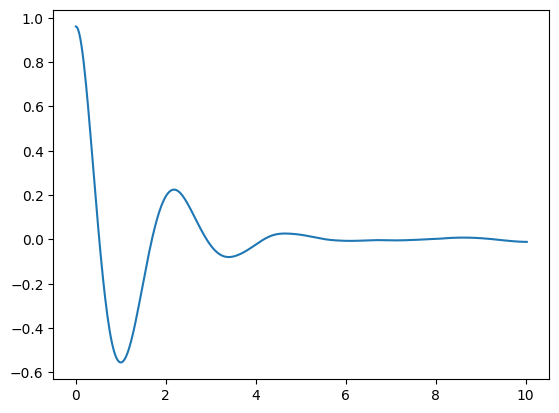

In [ ]:
t = np.arange(nstep+1)*dt
plt.plot(t, O)
plt.show()

Now finally, we will visualise what the subspace expansion scheme has done to the bond dimension of the TTN, using the `visualise_tree` function.


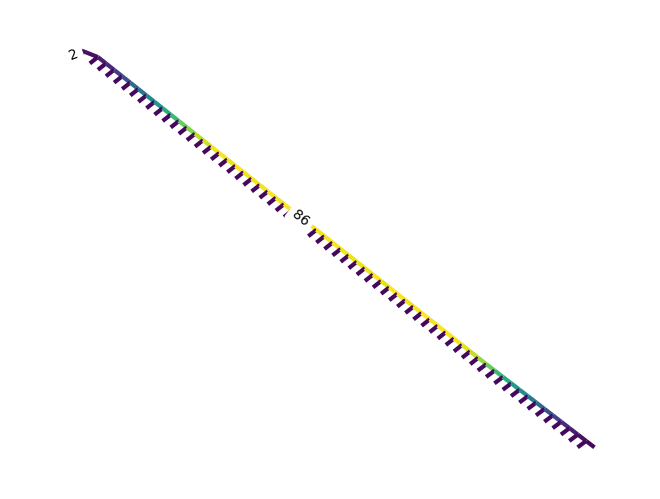

In [ ]:
visualise_tree(A, bond_prop="bond dimension", node_size=0)
plt.show()